In [502]:
#   NOTEBOOK STRUCTURE:
# STEP 0: imports and TRAIN/TEST BEHAVIOR
# 0.1: Train step
# 0.2: Test step
# 0.3: Loop
# STEP 1: DATA
# 1.1: Paths lists, validate?
# 1.2: Transforms, dataloaders 
# STEP 2: ARCHITECTURE
# STEP 3: Training loop
# STEP 4: ANALYSIS
# STEP 5: EXPORT

In [503]:
# STEP 0: Imports, init cuda

import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.5.1+cu121


'cuda'

In [504]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    total_loss = 0.0
    total_samples = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Accumulate loss
        total_loss += loss.item() * y.size(0)
        total_samples += y.size(0)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / total_samples


In [505]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    
    total_loss = 0.0
    total_samples = 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            # Accumulate weighted loss
            total_loss += loss.item() * y.size(0)
            total_samples += y.size(0)

    return total_loss / total_samples


In [526]:
# 0.3: Loop
from tqdm.auto import tqdm

results = {
    'train loss' : [],
    'test loss' : []
    }
def train_loop(model: torch.nn.Module,
            train_dataloader: torch.utils.data.DataLoader,
            test_dataloader: torch.utils.data.DataLoader,
            optimizer: torch.optim.Optimizer,
            loss_fn: torch.nn.Module,
            scheduler: torch.optim.lr_scheduler._LRScheduler,
            epochs: int):


    # loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer)
        test_loss = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        scheduler.step(test_loss)

        results['train loss'].append(train_loss)
        results['test loss'].append(test_loss)
        print(f"Epoch: {epoch+1}, Train loss: {train_loss}, Test loss: {test_loss}")

    return results

In [527]:
# STEP 1: DATA

# download latest version of data from kaggle 
raw_data = yf.download('^GSPC', start='2020-01-01', end='2022-01-01').reset_index()
data = pd.DataFrame({
    #'Date':raw_data[['Date']].values.ravel(),
    'Low':raw_data[['Low']].values.ravel(),
    'High':raw_data[['High']].values.ravel(),
    'Open':raw_data[['Open']].values.ravel(),
    'Close':raw_data[['Close']].values.ravel()
    })
data.dropna(inplace=True)

# add additional features using pandas libraries
import pandas_ta as ta
data['SMA'] = ta.sma(data['Close'], length=10)
data['EMA'] = ta.ema(data['Close'], length=20)
data['RSI'] = ta.rsi(data['Close'], length=14)
data['ROC'] = ta.roc(data['Close'])  # Rate of Change
data['RET'] = data['Close'].pct_change()

    # add target column, either:
# extract target variable (if looking for amount the ticker moves daily)
#target = [data['Open'][i]-data['Close'][i] for i in range(0, len(data))]
#data['Target'] = target
#data.dropna(inplace=True)

    # OR:
# extract target variable (if looking for final value of the ticker in one day)
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)

print(data)

#plt.plot(data.index, data['Close'])

C:\Users\zecer\AppData\Local\Temp\ipykernel_25316\553188175.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download('^GSPC', start='2020-01-01', end='2022-01-01').reset_index()
[*********************100%***********************]  1 of 1 completed

             Low         High         Open        Close          SMA  \
19   3242.800049  3285.909912  3256.449951  3283.659912  3298.690991   
20   3214.679932  3282.330078  3282.330078  3225.520020  3289.561987   
21   3235.659912  3268.439941  3235.659912  3248.919922  3281.491968   
22   3280.610107  3306.919922  3280.610107  3297.590088  3279.171973   
23   3313.750000  3337.580078  3324.909912  3334.689941  3280.465967   
..           ...          ...          ...          ...          ...   
499  4703.959961  4740.740234  4703.959961  4725.790039  4665.384033   
500  4733.990234  4791.490234  4733.990234  4791.189941  4673.301025   
501  4780.040039  4807.020020  4795.490234  4786.350098  4685.039014   
502  4778.080078  4804.060059  4788.640137  4793.060059  4700.936035   
503  4775.330078  4808.930176  4794.229980  4778.729980  4707.824023   

             EMA        RSI       ROC       RET       Target  
19   3280.837000  51.371588 -0.171165  0.003134  3225.520020  
20   3275

In [528]:
# STEP 1.2: Transforms, time-aware train-test split, dataloaders

from sklearn.preprocessing import MinMaxScaler

# num backcandles:
N = 30 # TODO COULD PUSH

# 1. Split raw data first (to avoid data leakage), unshuffled is appropriate for time series analysis 
split_idx = int(len(data) * 0.9)
data_train = data.iloc[:split_idx].copy()
data_test = data.iloc[split_idx:].copy()

# 2. Separate features and target
features_train = data_train.drop(columns=['Target']).values
target_train = data_train['Target'].values.reshape(-1, 1)

features_test = data_test.drop(columns=['Target']).values
target_test = data_test['Target'].values.reshape(-1, 1)

# 3. Fit scalers only on training data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
scaled_features_train = feature_scaler.fit_transform(features_train)
scaled_target_train = target_scaler.fit_transform(target_train)

# 4. Transform test data using fitted scalers
scaled_features_test = feature_scaler.transform(features_test)
scaled_target_test = target_scaler.transform(target_test)

# 5. Recombine scaled features and target
scaled_data_train = np.concatenate((scaled_features_train, scaled_target_train), axis=1)
scaled_data_test = np.concatenate((scaled_features_test, scaled_target_test), axis=1)

# 6. Make backcandles
def generate_backcandles(data, target_col, n):
    X, y = [], []
    for i in range(n, len(data)):
        input_candle = np.delete(data[i - n:i], target_col, axis=1)  # shape: (n, num_features)
        X.append(input_candle)
        y.append(data[i, target_col])  # scalar target

    X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y = torch.tensor(np.array(y).reshape(-1, 1), dtype=torch.float32).to(device)
    return X, y

# 7. Generate train/test tensors
target_col_index = scaled_data_train.shape[1] - 1  # same for both sets
X_train, y_train = generate_backcandles(scaled_data_train, target_col=target_col_index, n=N)
X_test, y_test = generate_backcandles(scaled_data_test, target_col=target_col_index, n=N)

# 8. Create TensorDatasets and Dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

BATCH_SIZE = 32  # fixed batch size for consistency
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 9. Inspect shapes
print(f"X shape: {X_train.shape[0] + X_test.shape[0], N, X_train.shape[2]}")
print(f"y shape: {y_train.shape[0] + y_test.shape[0], 1}")


X shape: (425, 30, 9)
y shape: (425, 1)


In [529]:
# Step 2: Architecture

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=3, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

        # Additional dense block 
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)               # out: [batch_size, seq_len, hidden_size]
        out = self.norm(out[:, -1, :])      # Take only last time step
        out = self.dropout(out)
        return self.fc(out)                 # Output: [batch_size, 1]

# Instantiate using input size (number of features)
model = MyLSTM(input_size=X_train.shape[2]).to(device)


In [530]:
# STEP 3: Loss fn, optimizer, dummy forward pass

# reasonably good choices depend on data
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)


# dummy forward pass
batch, label_batch = next(iter(train_loader))
input, label = batch[0].unsqueeze(dim=0), label_batch[0] 

model.eval()
with torch.inference_mode():
  pred = model(input.to(device))

pred

tensor([[0.1435]], device='cuda:0')

In [531]:
# STEP 3: Training loop

from timeit import default_timer as timer
start_time = timer()

# Training begins here
NUM_EPOCHS = 50
model_results = train_loop(model=model,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        scheduler=scheduler,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.1442441662837719, Test loss: 0.07291668653488159
Epoch: 2, Train loss: 0.021469890786876233, Test loss: 0.012813648208975792
Epoch: 3, Train loss: 0.015520304487329986, Test loss: 0.001157962717115879
Epoch: 4, Train loss: 0.011613242653900473, Test loss: 0.004483991768211126
Epoch: 5, Train loss: 0.010186059987677142, Test loss: 0.0018142912304028869
Epoch: 6, Train loss: 0.010464585964278928, Test loss: 0.0009516295394860208
Epoch: 7, Train loss: 0.01074256422227533, Test loss: 0.0008398302597925067
Epoch: 8, Train loss: 0.010387838077203834, Test loss: 0.010668514296412468
Epoch: 9, Train loss: 0.008757576566611604, Test loss: 0.0021177621092647314
Epoch: 10, Train loss: 0.009670424747643212, Test loss: 0.0013495817547664046
Epoch: 11, Train loss: 0.010357581936924034, Test loss: 0.0007488505216315389
Epoch: 12, Train loss: 0.007982823360032342, Test loss: 0.004091518931090832
Epoch: 13, Train loss: 0.009519079016530749, Test loss: 0.0038981344550848007
Epoch

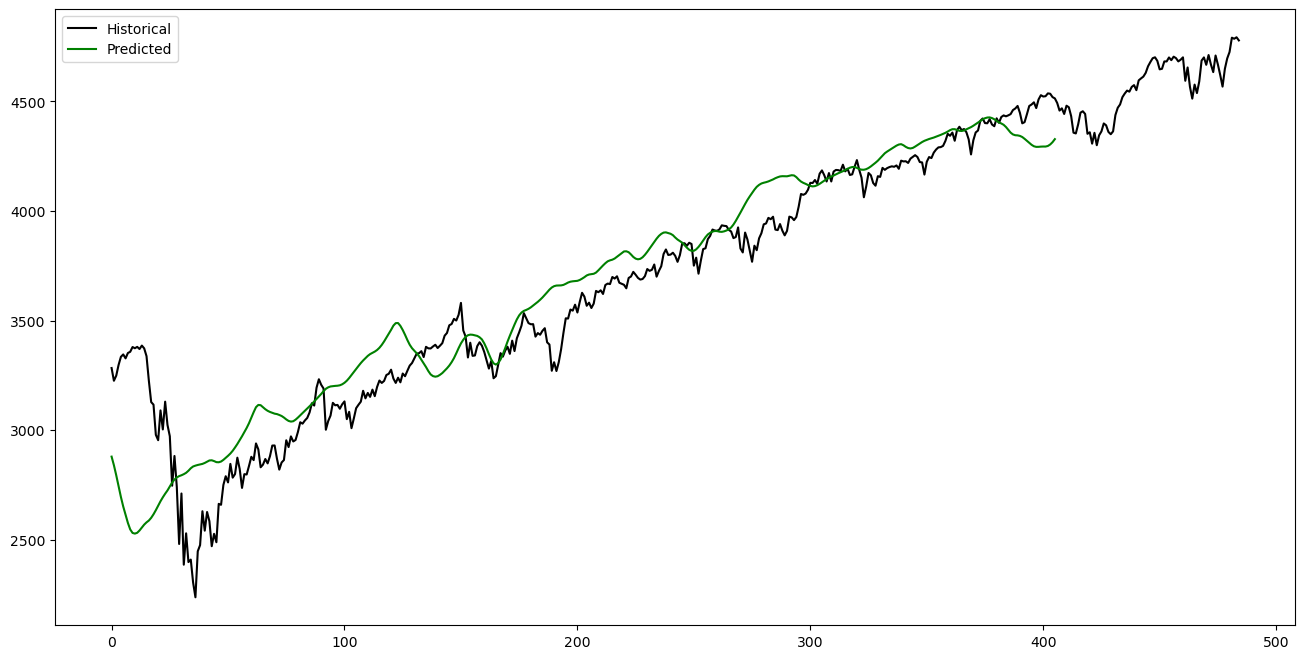

In [ ]:
# STEP 4: ANALYSIS



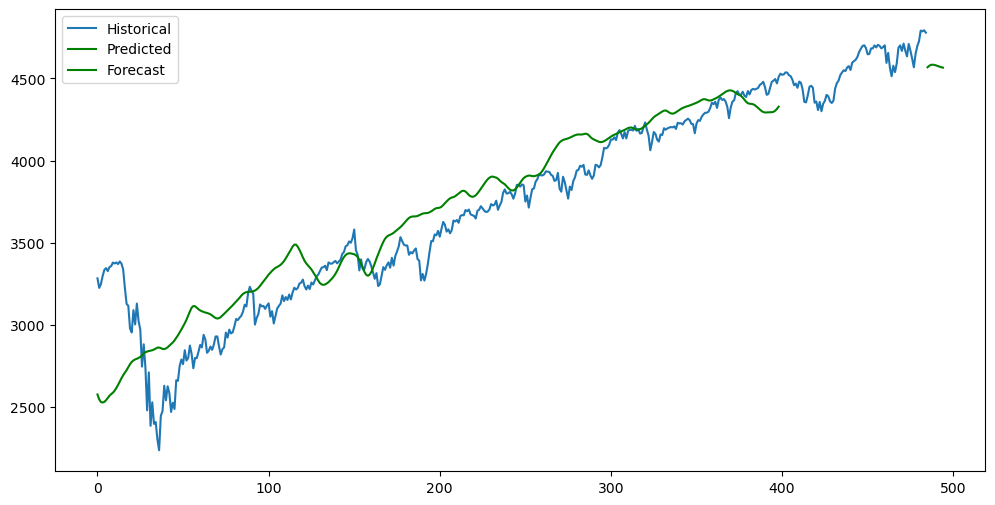

In [ ]:
# STEP 4.5: ROLL FORWARD
# TODO ^

# Take last N rows of feature columns
last_window = data.iloc[-N:, :-1].values  # shape: (N, features)
last_window_scaled = feature_scaler.transform(last_window)

future_preds = []

# Start with the most recent window
current_window = last_window_scaled.copy()  # shape: (N, features)

K = 10
for _ in range(K):  # Predict K steps ahead
    # Prepare input tensor
    inp_tensor = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).to(device)  # (1, N, features)

    # Predict next target
    with torch.no_grad():
        y_scaled = model(inp_tensor)

    # Inverse scale prediction
    y_real = target_scaler.inverse_transform(y_scaled.cpu().numpy())[0][0]
    future_preds.append(y_real)

    # Create dummy next row: replace Close with predicted value, other features repeat last row
    next_row = current_window[-1].copy()
    next_row[-1] = y_scaled.item()  # overwrite Close (assumed to be last column)

    # Slide window forward
    current_window = np.vstack([current_window[1:], next_row])

plt.figure(figsize=(12,6))
plt.plot(data['Close'].values, label='Historical')
plt.plot(y_preds[shift:], label='Predicted', color='green')
plt.plot(range(len(data), len(data) + K), future_preds, label='Forecast', color='green')
plt.legend()
plt.show()



In [447]:
# STEP 5: EXPORT

# save and load as pytorch file (.pt) INFERENCE ONLY
pt_path = 'model.pt'
torch.save(model.state_dict(), pt_path)
model = MyLSTM(input_size=X_train.shape[2]) # match correct model architecture
model.load_state_dict(torch.load(pt_path, weights_only=True))

model.eval()
model = model.to(device)
# dummy forward pass
batch, label_batch = next(iter(train_loader))
input, label = batch[0].unsqueeze(dim=0), label_batch[0] 
with torch.inference_mode():
  pred = model(input.to(device))

pred

tensor([[0.9492]], device='cuda:0')

In [494]:
# load and export as .onnx file INFERENCE ONLY

pt_model = MyLSTM(input_size=X_train.shape[2]) # match correct model architecture
pt_model.load_state_dict(torch.load(pt_path))
pt_model.eval()
ex_input = (torch.zeros(1, N, len(data.columns)-1, dtype=torch.float32)).to(device) # match correct input dimenstions
torch.onnx.export(
    model,
    ex_input,
    "lstm_model.onnx",
    export_params=True,            # <--- Ensures weights are stored internally
    do_constant_folding=True,
    opset_version=11,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    use_external_data_format=False
)

C:\Users\zecer\AppData\Local\Temp\ipykernel_25316\1304242298.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_model.load_state_dict(torch.load(pt_path))
c:\Users\zecer

In [495]:
import onnx, onnxruntime as ort
onnx_path = 'C:/Users/zecer/proj/github/pytorch-pipeline/lstm_model.onnx'
onnx.checker.check_model(onnx_path)  # should raise no errors

ex_input = (torch.zeros(1, N, len(data.columns)-1, dtype=torch.float32))

ort.InferenceSession(onnx_path).run(
    None, {"input": ex_input.numpy()}
)


[array([[0.02148743]], dtype=float32)]